<a href="https://colab.research.google.com/github/yudhaerian/UAS_BigData/blob/main/UasBigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<span style='font-family:serif'>
    
### <center> Movie Recommender System using PySpark </center>



In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 48 kB/s 
     |████████████████████████████████| 199 kB 46.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=2dbf322144549532fa2bd956398396254ccb735979a076fd1d91e9e24a079425
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
# Creating spark session 
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql import functions as f
from pyspark.sql.types import *

spark = SparkSession.builder.appName("movierecommender") \
.config(conf=SparkConf([('spark.executor.memory', '16g'), 
                        ('spark.app.name', 'Spark Updated Conf'), 
                        ('spark.executor.cores', '6'), 
                        ('spark.cores.max', '6'), 
                        ('spark.driver.memory','16g')])) \
.getOrCreate()

<div style="font-size: 14px">
    
<span style='font-family:Georgia'>
    
Data Source: 

The datasets describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.    

In [3]:
# Loading data
movies = spark.read.format("csv").option("header", "true").load("/content/movie.csv",inferSchema="true")
ratings = spark.read.format("csv").option("header", "true").load("/content/rating.csv",inferSchema="true")

In [4]:
# Preprocessing data for exploratory data analysis
movielens = ratings.join(movies,["movieId"],"left")
movielens.summary().show()

+-------+------------------+------------------+------------------+-------------------+--------------------+------------------+
|summary|           movieId|            userId|            rating|          timestamp|               title|            genres|
+-------+------------------+------------------+------------------+-------------------+--------------------+------------------+
|  count|            508476|            508476|            508476|             508476|              508476|            508476|
|   mean| 8628.861291388384|1735.3688394339163|3.5192034628969706|               null|                null|              null|
| stddev|19124.033375674026| 990.4447191020721|1.0543033757022644|               null|                null|              null|
|    min|                 1|                 1|               0.5|1996-03-15 22:16:09|""Great Performan...|(no genres listed)|
|    25%|               899|               860|               3.0|               null|                null|    

In [5]:
# Final Schema for dataset
movielens.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



<div style="font-size: 14px">
    
<span style='font-family:Georgia'>
    
    
###  <center>  Train-Validation Split </center> 

We then create a 80/20 train-validation split of the movielens dataset for model evaluation purposes. The model is created and trained on the train set and tested on the validation set. 

In [6]:
# Train set test set split
(train_set,temp) = movielens.randomSplit([8.0,1.0],seed=1)

In [7]:
# Make sure userId and movieId in validation set are also in train set (to avoid Cold Start Problem)
validation_set = (temp
    .join(train_set,["userId"],"left_semi")
    .join(train_set,["movieId"],"left_semi"))

removed = (temp
 .join(validation_set,["movieId","userId"],"left_anti")
)

train_set = train_set.union(removed)

<div style="font-size: 14px">
    
<span style='font-family:Georgia'>
    
###  <center>  Exploratory Data Analysis </center> 

Data ingestion is followed by data exploration where we intend to gain some insights about the dataset we just loaded. We study each attribute and its characteristics like name, type, percentage of missing values, outliers, type of distribution and many others. The subsequent tasks include studying correlations between the attributes and identifying the promising transformations if needed. Data visualization is quite an important tool for accomplishing these tasks. We document all these intuitions thus obtained by summarizing and visualizing the dataset, aiding the understanding of the project.

With an initial glance of the movielens dataset, we observe that movie information is available in movieId and title columns; user information is available in userId column, timestamp is measured in seconds with “1970-01-01 UTC” as origin; rating column is our target variable; Each movie rating has been categorized into one or more genres which is available in genres column.

In [8]:
# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
%matplotlib inline  
plt.rcParams["figure.figsize"] = (10,8)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


> #### Rating

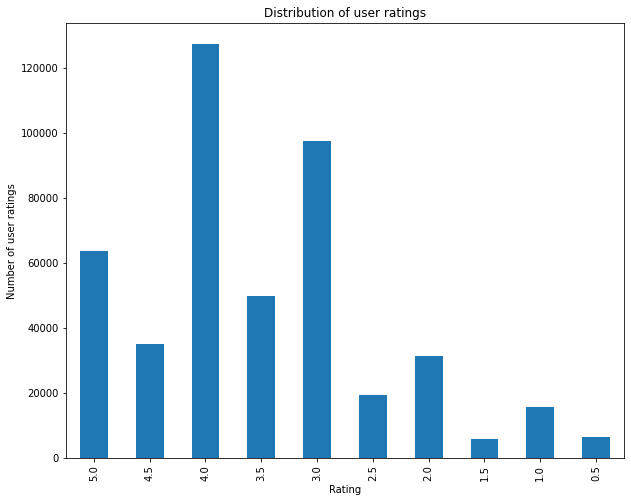

In [9]:
# Distribution of user ratings
ratings_hist=(train_set
 .groupBy(f.col("rating")).count()
 .sort(f.col("rating").desc())        
).toPandas()

ratings_hist.plot.bar("rating","count")
plt.title("Distribution of user ratings")
plt.xlabel("Rating")
plt.ylabel("Number of user ratings")
plt.legend().remove()

> #### MovieId & Title

Text(0, 0.5, 'Cumulative Frequency')

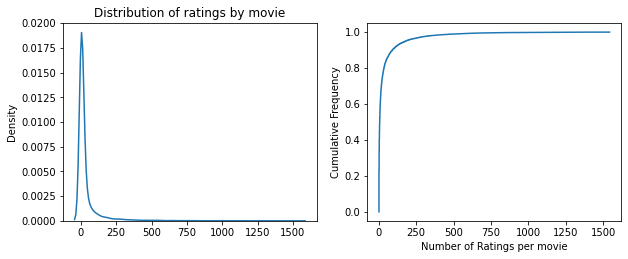

In [10]:
# Density Distribution and normalized ECDF of ratings grouped by movie
movies_ratings =(train_set
 .groupBy(f.col("movieId")).count()    
).toPandas()

plt.subplot(2, 2, 1)
sns.kdeplot(movies_ratings["count"])
plt.xlabel("")
plt.ylabel("Density")
plt.title("Distribution of ratings by movie")

plt.subplot(2,2,2)
plt.plot(ECDF(movies_ratings["count"]).x,ECDF(movies_ratings["count"]).y)
plt.xlabel("Number of Ratings per movie")
plt.ylabel("Cumulative Frequency")

> #### UserId

Text(0, 0.5, 'Cumulative Frequency')

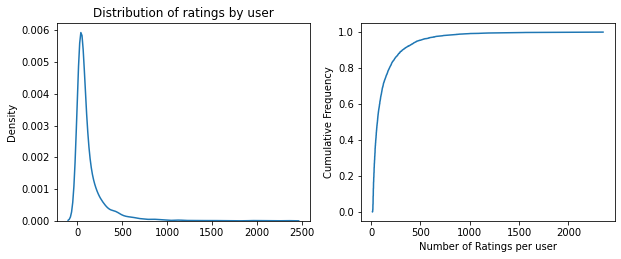

In [11]:
# Density Distribution and normalized ECDF of ratings grouped by user
user_ratings =(train_set
 .groupBy(f.col("userId")).count()    
).toPandas()

plt.subplot(2, 2, 1)
sns.kdeplot(user_ratings["count"])
plt.xlabel("")
plt.ylabel("Density")
plt.title("Distribution of ratings by user")

plt.subplot(2,2,2)
plt.plot(ECDF(user_ratings["count"]).x,ECDF(user_ratings["count"]).y)
plt.xlabel("Number of Ratings per user")
plt.ylabel("Cumulative Frequency")

> #### Genres

Text(0.5, 1.0, 'Visualizing number of movies in each genre')

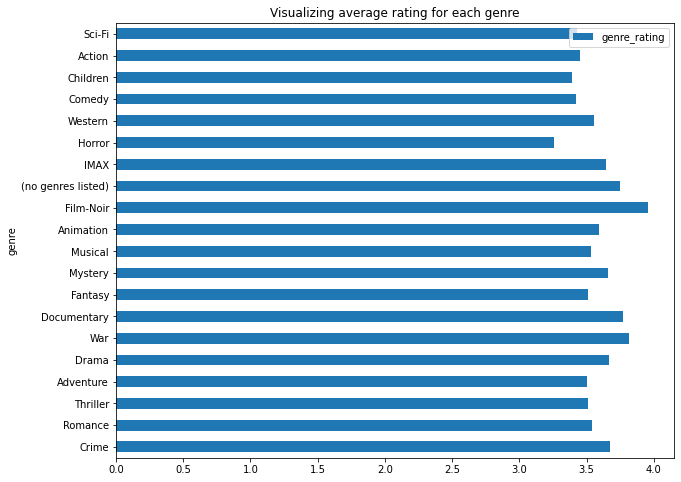

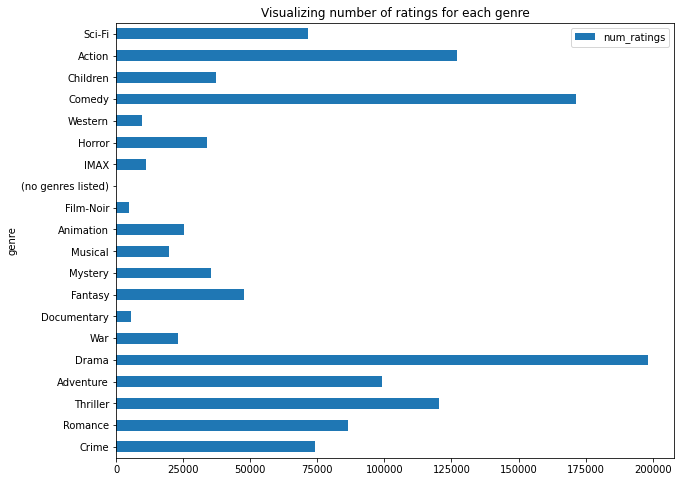

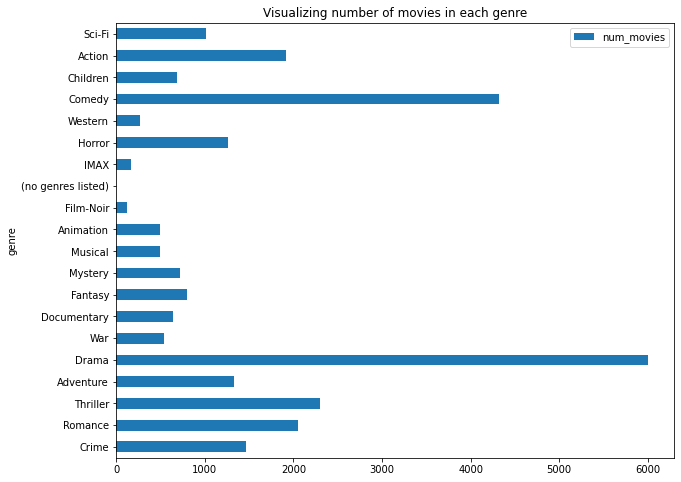

In [12]:
# Average rating of movies based on genre
avg_genre_rating = (train_set
 .select("movieId","userId","genres","rating")
 .withColumn("genres_array", f.split("genres", "\|"))
 .withColumn("genre", f.explode("genres_array"))
 .groupBy("genre").agg(f.mean(f.col("rating")).alias("genre_rating"),
                       f.countDistinct("movieId").alias("num_movies"),
                       f.countDistinct("movieId","userId").alias("num_ratings"))
).toPandas()


avg_genre_rating.plot.barh("genre","genre_rating")
plt.title("Visualizing average rating for each genre")
avg_genre_rating.plot.barh("genre","num_ratings")
plt.title("Visualizing number of ratings for each genre")
avg_genre_rating.plot.barh("genre","num_movies")
plt.title("Visualizing number of movies in each genre")

> #### Timestamp

Text(0.5, 1.0, 'Visualizing number of movies rated each day')

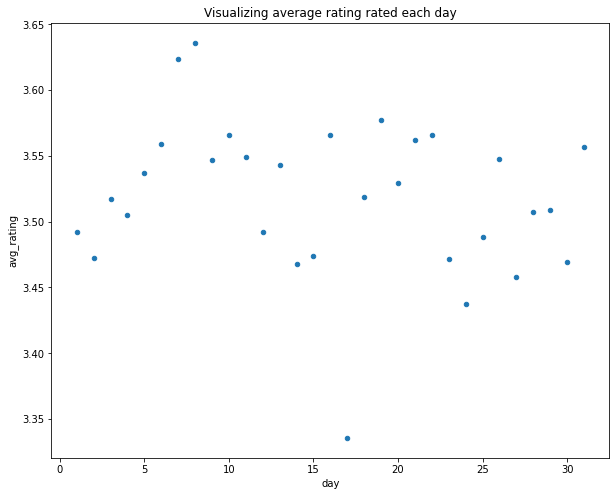

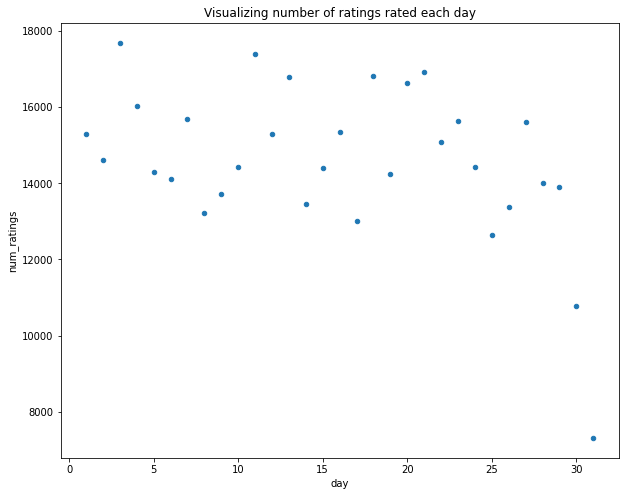

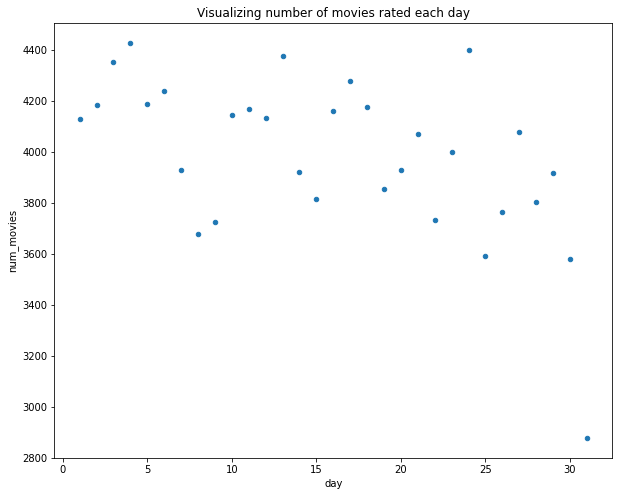

In [13]:
# Analyzing day of the month - Timestamp of rating
day_month_rating = (train_set
 .withColumnRenamed("timestamp","date")
 .withColumn("day",f.dayofmonth(f.col("date")))
 .groupBy("day").agg(f.mean(f.col("rating")).alias("avg_rating"),
                     f.countDistinct("movieId").alias("num_movies"),
                     f.countDistinct("movieId","userId").alias("num_ratings"))
).toPandas()

day_month_rating.plot.scatter("day","avg_rating")
plt.title("Visualizing average rating rated each day")
day_month_rating.plot.scatter("day","num_ratings")
plt.title("Visualizing number of ratings rated each day")
day_month_rating.plot.scatter("day","num_movies")
plt.title("Visualizing number of movies rated each day")

Text(0.5, 1.0, 'Visualizing number of movies rated each day')

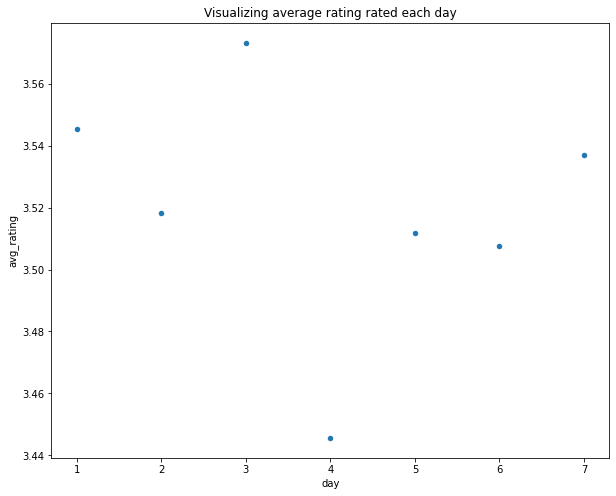

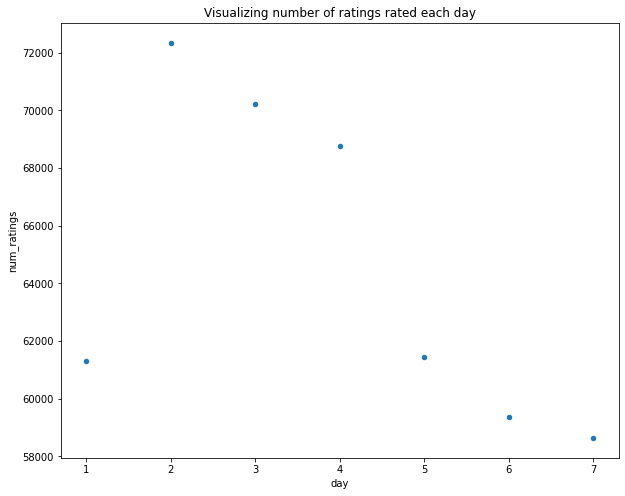

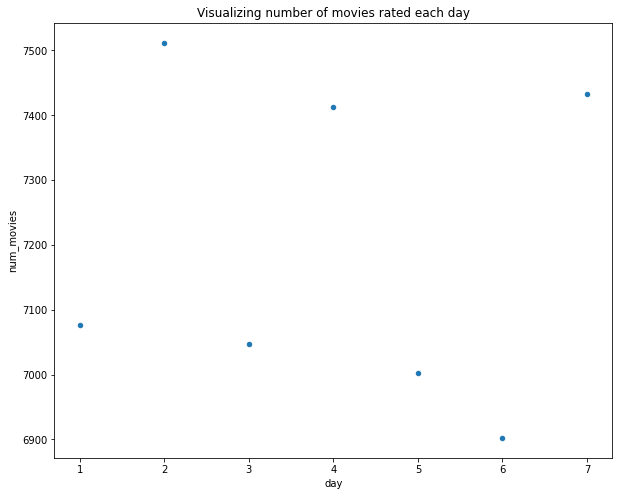

In [14]:
# Analyzing day of the week - Timestamp of rating
day_week_rating = (train_set
 .withColumnRenamed("timestamp","date")
 .withColumn("day",f.dayofweek(f.col("date")))
 .groupBy("day").agg(f.mean(f.col("rating")).alias("avg_rating"),
                     f.countDistinct("movieId").alias("num_movies"),
                     f.countDistinct("movieId","userId").alias("num_ratings"))
).toPandas()

day_week_rating.plot.scatter("day","avg_rating")
plt.title("Visualizing average rating rated each day")
day_week_rating.plot.scatter("day","num_ratings")
plt.title("Visualizing number of ratings rated each day")
day_week_rating.plot.scatter("day","num_movies")
plt.title("Visualizing number of movies rated each day")

> #### Release Year

Text(0.5, 1.0, 'Visualizing number of movies vs Release Year')

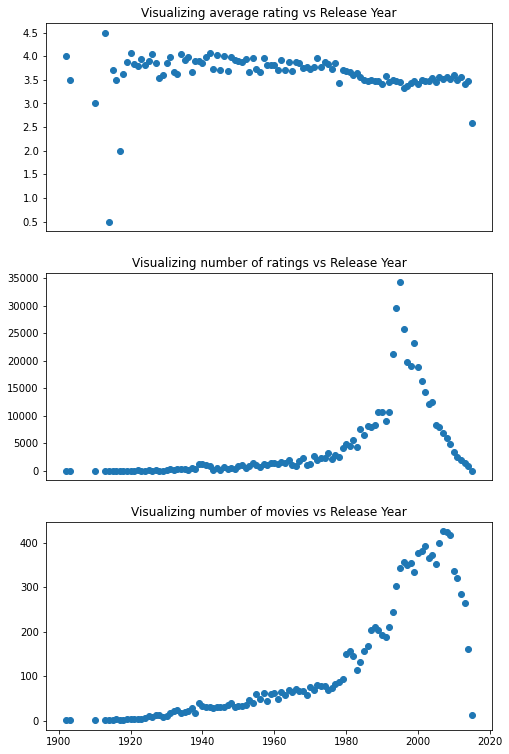

In [15]:
release_year_rating = (train_set
 .select("title","movieId","userId","rating")
 .withColumn("releaseyear",f.substring('title',-5,4))
 .filter(f.col("releaseyear")>1900)
 .groupBy("releaseyear").agg(f.mean(f.col("rating")).alias("avg_rating"),
                             f.countDistinct("movieId").alias("num_movies"),
                             f.countDistinct("movieId","userId").alias("num_ratings"))
).toPandas()

plt.figure(figsize=(8,13))
plt.subplot(3, 1, 1)
plt.scatter(release_year_rating.releaseyear.astype('int64'),release_year_rating.avg_rating)
plt.title("Visualizing average rating vs Release Year")
plt.xticks([])
plt.subplot(3, 1, 2)
plt.scatter(release_year_rating.releaseyear.astype('int64'),release_year_rating.num_ratings)
plt.title("Visualizing number of ratings vs Release Year")
plt.xticks([])
plt.subplot(3, 1, 3)
plt.scatter(release_year_rating.releaseyear.astype('int64'),release_year_rating.num_movies)
plt.title("Visualizing number of movies vs Release Year")

> ### Building a recommender system using ALS 

In [16]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [17]:
# Basic Model parameters
als = ALS(
        userCol = "userId",
        itemCol = "movieId",
        ratingCol = "rating",
)

In [18]:
# Evaluator
evaluator = RegressionEvaluator(
    metricName = "rmse",
    labelCol = "rating", 
    predictionCol = "prediction"
)
# Fit and Transform
model = als.fit(train_set)
predictions = model.transform(validation_set)

In [19]:
rmse = evaluator.evaluate(predictions.na.drop())
print(rmse)

0.8325465592576153


In [20]:

# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# # Creating Hyperparameter grid for tuning the model 
# parameter_grid = (
#     ParamGridBuilder()
#     .addGrid(als.rank ,[1,5,10])
#     .addGrid(als.maxIter,[20])
#     .addGrid(als.regParam,[0.05,0.1])
#     .build()
# )

# # Cross validation on the hyperparameter grid
# crossvalidator = CrossValidator(
#     estimator=als,
#     estimatorParamMaps=parameter_grid,
#     evaluator=evaluator,
#     numFolds=1,
# )
# # Model fitting and predictions
# crossval_model = crossvalidator.fit(train_set)
# predictions = crossval_model.transform(validation_set)

In [21]:
# rmse = evaluator.evaluate(predictions)
# print(rmse)

In [22]:
# opt_model = crossval_model.bestModel
# opt_model

<div style="font-size: 14px">
    
<span style='font-family:Georgia'>
    
#### <center> Recommendations for All users  </center>
 
In this section, we generate recommendations based on the requirements. 

Recommendations can be generated for all users, a list of users, or a single user.

In [23]:
# Recommending top 10 movies for all users
recommend_all_users = model.recommendForAllUsers(10).cache()
recommend_all_users.show(20,False)

+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                  |
+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1580  |[{3309, 6.053791}, {25963, 5.503982}, {66915, 5.490786}, {3958, 5.215984}, {6967, 5.038321}, {3805, 4.842602}, {392, 4.838814}, {32591, 4.7912517}, {2647, 4.768701}, {45028, 4.743746}]         |
|471   |[{6823, 5.1171083}, {1685, 4.7920117}, {4405, 4.668901}, {6600, 4.6492233}, {26270, 4.639888}, {5301, 4.6348133}, {7577, 4.6176157}, {7941, 4.5965695}, {727, 4.557924}, {108548, 4.

#### <center>  Detailed recommendation for the selected user </center>

In [24]:
# Checking movie title from the previous generated recommendations
USER_ID = 1238
(
    recommend_all_users
    .filter(f"userId == {USER_ID}")
    .withColumn("rec",f.explode("recommendations"))
    .select("userId",
            f.col("rec").movieId.alias("movieId"),
            f.col("rec").rating.alias("rating"),
           )
    .join(movies,"movieId")
    .orderBy("rating",ascending=False)
    .select("movieId","title")
).show(truncate=False)

+-------+----------------------------------------------+
|movieId|title                                         |
+-------+----------------------------------------------+
|6823   |Under Suspicion (1992)                        |
|727    |War Stories (1995)                            |
|4405   |Last Laugh, The (Letzte Mann, Der) (1924)     |
|5301   |Bite the Bullet (1975)                        |
|6516   |Anastasia (1956)                              |
|105943 |Bridegroom (2013)                             |
|1685   |I Love You, I Love You Not (1996)             |
|31545  |Trou, Le (Hole, The) (Night Watch, The) (1960)|
|72142  |Love Exposure (Ai No Mukidashi) (2008)        |
|33270  |Taste of Tea, The (Cha no aji) (2004)         |
+-------+----------------------------------------------+



#### <center>  Recommendation for a particular user based on predictions for unwatched movies</center>

In [25]:
# Consider any random user from the userId
USER_ID = 1238 

# Movies not rated by the selected user
movies_to_be_rated = (
    ratings
    .filter(f"userId != {USER_ID}")
    .select("movieId").distinct()
    .withColumn("userId",f.lit(USER_ID))
)
# Predictions on unwatched movies only
user_movie_preds = model.transform(movies_to_be_rated)
user_movie_preds.show()

# Movie recommendations for userId - Manually feeding unwatched movies
(user_movie_preds
.dropna()
.orderBy("prediction",ascending = False)
.limit(10)
.join(movies,["movieId"])
.select("userId","movieId","title",f.col("prediction").alias("rating"))
.orderBy("rating",ascending = False)
).show(truncate=False)

+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
|   3997|  1238| 1.8920559|
|   1580|  1238|  3.557437|
|   3918|  1238| 3.4078836|
|   2366|  1238| 3.5876257|
|   3175|  1238|  3.757062|
|   4519|  1238| 2.7130153|
|   1591|  1238|  2.403667|
|    471|  1238|  3.663123|
|  36525|  1238| 2.8590555|
|  44022|  1238| 3.0768778|
|   2866|  1238| 3.7042205|
|   1645|  1238| 3.3860493|
|   5803|  1238|  2.093069|
|  54190|  1238| 3.3753376|
|   1088|  1238| 3.1237454|
|    833|  1238|  2.334458|
|   8638|  1238| 3.9444218|
|    463|  1238| 2.6578653|
|   1959|  1238|  3.827234|
|   2659|  1238| 3.4756281|
+-------+------+----------+
only showing top 20 rows

+------+-------+----------------------------------------------+---------+
|userId|movieId|title                                         |rating   |
+------+-------+----------------------------------------------+---------+
|1238  |6823   |Under Suspicion (1992)                        |5.0846114|
|1238 